### 引入套件

In [1]:
from datetime import datetime
import backtrader as bt
import yfinance as yf
import pandas as pd

### 回測計算函式

In [2]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')

### 買賣股票策略函式

In [3]:
class MACDStrategy(bt.Strategy):
    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.order = None

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            if self.mcross[0] > 0.0: 
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy()

        else:
            # sell condition
            if self.mcross[0] < 0.0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell()

### 取得目標股票的歷史資料

In [4]:
data= yf.download(  '2330.tw',              #股票代碼
                    period = '2y',
                    progress=False
                 )
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

### 台股交易費用計算的函式

In [5]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
        if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
        else:
            return (max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)-size * price *self.p.tax)

### 建立回測分析

In [6]:
# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(MACDStrategy)
cerebro.broker.setcash(1000.0)

# commission 手續費 0.1425%
# discount 可以拿到的手續費折數
# tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.5,
    tax=0.003,
    lowestfee=1
)

cerebro.broker.addcommissioninfo(comminfo)

### 開始回測

In [7]:
# run backtest
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2023-01-10, 開出買單 --- 當時市場價格: 486.00
2023-01-11, 買單執行 --- 買價: 487.00, 成本: 487.00, 手續費: 1.00
2023-02-15, 開出賣單 --- 當時市場價格: 525.00
2023-02-16, 賣單執行 --- 賣價: 528.00, 成本: 487.00, 手續費: 2.58
2023-02-16, 運作結果 --- 獲利狀況: 41.00, 淨獲利: 37.42
2023-03-22, 開出買單 --- 當時市場價格: 533.00
2023-03-23, 買單執行 --- 買價: 528.00, 成本: 528.00, 手續費: 1.00
2023-04-11, 開出賣單 --- 當時市場價格: 524.00
2023-04-12, 賣單執行 --- 賣價: 523.00, 成本: 528.00, 手續費: 2.57
2023-04-12, 運作結果 --- 獲利狀況: -5.00, 淨獲利: -8.57
2023-05-09, 開出買單 --- 當時市場價格: 510.00
2023-05-10, 買單執行 --- 買價: 508.00, 成本: 508.00, 手續費: 1.00
2023-06-21, 開出賣單 --- 當時市場價格: 581.00
2023-06-26, 賣單執行 --- 賣價: 576.00, 成本: 508.00, 手續費: 2.73
2023-06-26, 運作結果 --- 獲利狀況: 68.00, 淨獲利: 64.27
2023-07-17, 開出買單 --- 當時市場價格: 591.00
2023-07-18, 買單執行 --- 買價: 587.00, 成本: 587.00, 手續費: 1.00
2023-07-18, 開出賣單 --- 當時市場價格: 581.00
2023-07-19, 賣單執行 --- 賣價: 584.00, 成本: 587.00, 手續費: 2.75
2023-07-19, 運作結果 --- 獲利狀況: -3.00, 淨獲利: -6.75
2023-08-24, 開出買單 --- 當時市場價格: 564.00
2023-08-25, 買單執行 --- 買

### 視覺化回測結果

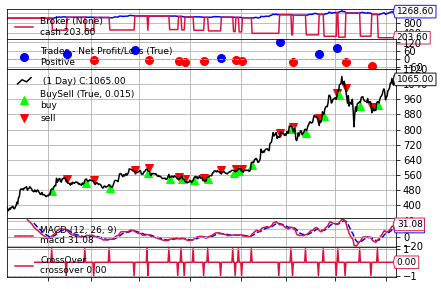

[[<Figure size 432x288 with 5 Axes>]]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot results
cerebro.plot(iplot=False, volume=False)

### 使用 Analyzer 來查看策略細節

In [9]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())

2023-01-10, 開出買單 --- 當時市場價格: 486.00
2023-01-11, 買單執行 --- 買價: 487.00, 成本: 487.00, 手續費: 1.00
2023-02-15, 開出賣單 --- 當時市場價格: 525.00
2023-02-16, 賣單執行 --- 賣價: 528.00, 成本: 487.00, 手續費: 2.58
2023-02-16, 運作結果 --- 獲利狀況: 41.00, 淨獲利: 37.42
2023-03-22, 開出買單 --- 當時市場價格: 533.00
2023-03-23, 買單執行 --- 買價: 528.00, 成本: 528.00, 手續費: 1.00
2023-04-11, 開出賣單 --- 當時市場價格: 524.00
2023-04-12, 賣單執行 --- 賣價: 523.00, 成本: 528.00, 手續費: 2.57
2023-04-12, 運作結果 --- 獲利狀況: -5.00, 淨獲利: -8.57
2023-05-09, 開出買單 --- 當時市場價格: 510.00
2023-05-10, 買單執行 --- 買價: 508.00, 成本: 508.00, 手續費: 1.00
2023-06-21, 開出賣單 --- 當時市場價格: 581.00
2023-06-26, 賣單執行 --- 賣價: 576.00, 成本: 508.00, 手續費: 2.73
2023-06-26, 運作結果 --- 獲利狀況: 68.00, 淨獲利: 64.27
2023-07-17, 開出買單 --- 當時市場價格: 591.00
2023-07-18, 買單執行 --- 買價: 587.00, 成本: 587.00, 手續費: 1.00
2023-07-18, 開出賣單 --- 當時市場價格: 581.00
2023-07-19, 賣單執行 --- 賣價: 584.00, 成本: 587.00, 手續費: 2.75
2023-07-19, 運作結果 --- 獲利狀況: -3.00, 淨獲利: -6.75
2023-08-24, 開出買單 --- 當時市場價格: 564.00
2023-08-25, 買單執行 --- 買價: 549.00, 成本: 549.00, 手續費: 1.00
2